In [1]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [2]:
# https://www.kaggle.com/datasets/sriharshaeedala/financial-fraud-detection-dataset/data
!kaggle datasets download -d sriharshaeedala/financial-fraud-detection-dataset

Dataset URL: https://www.kaggle.com/datasets/sriharshaeedala/financial-fraud-detection-dataset
License(s): CC-BY-SA-4.0
 96% 171M/178M [00:02<00:00, 76.0MB/s]
100% 178M/178M [00:02<00:00, 83.9MB/s]


In [3]:
!unzip financial-fraud-detection-dataset.zip

Archive:  financial-fraud-detection-dataset.zip
  inflating: Synthetic_Financial_datasets_log.csv  


In [4]:
import pandas as pd

df = pd.read_csv('/content/Synthetic_Financial_datasets_log.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
# selecting the columns of numerical type
numeric_columns = df.select_dtypes(include=['int', 'float']).columns

numeric_data = df[numeric_columns]

# pearson corrleation matrix of the numerical data
correlation = numeric_data.corr()
target_correlation = correlation['isFraud'].drop('isFraud')
threshold= 0.02
features=target_correlation[abs(target_correlation) >= threshold].index
features=features[:2]
copy_df=df[features].join(df['type'])
copy_df=copy_df.join(df['isFraud'])
df=copy_df
df.head()

,step,amount,type,isFraud
0,1,9839.64,PAYMENT,0
1,1,1864.28,PAYMENT,0
2,1,181.00,TRANSFER,1
3,1,181.00,CASH_OUT,1
4,1,11668.14,PAYMENT,0


In [6]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

le = LabelEncoder()
df['type'] = le.fit_transform(df['type'])

In [7]:
scaler = MinMaxScaler()
df['amount'] = scaler.fit_transform(df[['amount']])

In [8]:
df.head()

,step,amount,type,isFraud
0,1,0.000106,3,0
1,1,0.000020,3,0
2,1,0.000002,4,1
3,1,0.000002,1,1
4,1,0.000126,3,0


In [9]:
X = df.drop('isFraud', axis=1)
y = df['isFraud']

In [10]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

Missing values:
 step       0
amount     0
type       0
isFraud    0
dtype: int64

Number of duplicate rows: 7597

Data types:
 step         int64
amount     float64
type         int64
isFraud      int64
dtype: object

Distribution of 'isFraud':
 isFraud
0    6354407
1       8213
Name: count, dtype: int64


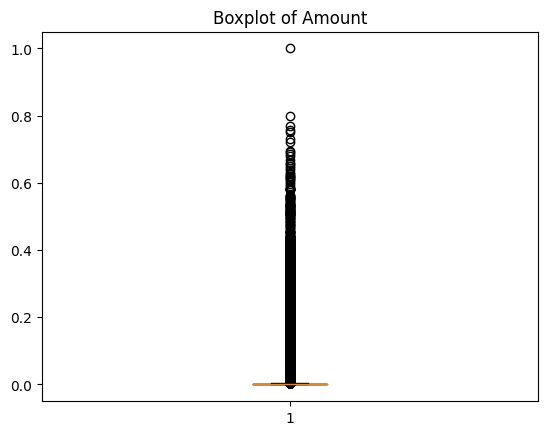

In [11]:
missing_values = df.isnull().sum()
print("Missing values:\n", missing_values)

duplicate_rows = df.duplicated().sum()
print("\nNumber of duplicate rows:", duplicate_rows)
print("\nData types:\n", df.dtypes)

fraud_counts = df['isFraud'].value_counts()
print("\nDistribution of 'isFraud':\n", fraud_counts)

import matplotlib.pyplot as plt
plt.boxplot(df['amount'])
plt.title('Boxplot of Amount')
plt.show()

In [ ]:
df.drop_duplicates(inplace=True)

In [12]:
import matplotlib.pyplot as plt
def handle_outliers_iqr(df, column):
  Q1 = df[column].quantile(0.25)
  Q3 = df[column].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  df[column] = df[column].clip(lower_bound, upper_bound)
  return df

df = handle_outliers_iqr(df, 'amount')

In [13]:
y_smote.value_counts()

,count
isFraud,
0,6354407
1,6354407


In [15]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, Embedding, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


def build_cgan_generator(input_dim, embedding_dim, output_dim):
    noise_input = Input(shape=(input_dim,))
    label_input = Input(shape=(1,))
    label_embedding = Embedding(input_dim=2, output_dim=embedding_dim)(label_input)
    label_embedding = tf.keras.layers.Flatten()(label_embedding)

    merged_input = Concatenate()([noise_input, label_embedding])
    x = Dense(64)(merged_input)
    x = LeakyReLU(alpha=0.1)(x)
    x = Dense(128)(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Dense(256)(x)
    x = LeakyReLU(alpha=0.1)(x)
    output_layer = Dense(output_dim, activation='tanh')(x)
    model = Model([noise_input, label_input], output_layer)
    return model


def build_cgan_discriminator(input_dim):
    input_layer = Input(shape=(input_dim,))
    label_input = Input(shape=(1,))
    label_embedding = Embedding(input_dim=2, output_dim=10)(label_input)
    label_embedding = tf.keras.layers.Flatten()(label_embedding)
    merged_input = Concatenate()([input_layer, label_embedding])

    x = Dense(128)(merged_input)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(64)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.3)(x)
    x = Dense(32)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(16)(x)
    x = LeakyReLU(alpha=0.2)(x)
    output_layer = Dense(1, activation='sigmoid')(x)
    model = Model([input_layer, label_input], output_layer)
    return model

def build_cgan(generator, discriminator):
    discriminator.trainable = False
    noise_input = Input(shape=(generator.input[0].shape[1],))
    label_input = Input(shape=(1,))
    x = generator([noise_input, label_input])
    gan_output = discriminator([x, label_input])
    gan = Model([noise_input, label_input], gan_output)
    return gan

input_dim = X_smote.shape[1]
output_dim = X_smote.shape[1]
embedding_dim = 10  # Adjust as needed

cgan_generator = build_cgan_generator(input_dim, embedding_dim, output_dim)
cgan_discriminator = build_cgan_discriminator(output_dim)
cgan = build_cgan(cgan_generator, cgan_discriminator)

optimizer = Adam(learning_rate=0.00001)
cgan_discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
cgan.compile(loss='binary_crossentropy', optimizer=optimizer)

epochs = 1000
batch_size = 256

for epoch in range(epochs):
    # Train discriminator
    noise = tf.random.normal([batch_size, input_dim])
    labels = tf.random.uniform(shape=[batch_size], minval=0, maxval=2, dtype=tf.int32)  # Assuming 2 classes
    generated_data = cgan_generator.predict([noise, labels])
    real_data = X_smote.sample(n=batch_size)
    real_labels = y_smote[real_data.index]

    X_batch = tf.concat([real_data, generated_data], axis=0)
    y_batch = tf.concat([tf.ones(batch_size), tf.zeros(batch_size)], axis=0)
    label_batch = tf.concat([real_labels, labels], axis=0)


    discriminator_loss, discriminator_acc = cgan_discriminator.train_on_batch([X_batch, label_batch], y_batch)

    # Train generator
    noise = tf.random.normal([batch_size, input_dim])
    labels = tf.random.uniform(shape=[batch_size], minval=0, maxval=2, dtype=tf.int32)
    y_gen = tf.ones(batch_size)
    generator_loss = cgan.train_on_batch([noise, labels], y_gen)

    print(f"Epoch: {epoch}, Discriminator Loss: {discriminator_loss}, Discriminator Accuracy: {discriminator_acc}, Generator Loss: {generator_loss}")

# Generate synthetic data with labels
noise = tf.random.normal([1000, input_dim])
labels = tf.random.uniform(shape=[1000], minval=0, maxval=2, dtype=tf.int32)
synthetic_data = cgan_generator.predict([noise, labels])


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
Epoch: 0, Discriminator Loss: 0.7344962358474731, Discriminator Accuracy: 0.7421875, Generator Loss: [array(0.73449624, dtype=float32), array(0.73449624, dtype=float32), array(0.7421875, dtype=float32)]
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Epoch: 1, Discriminator Loss: 0.7024288773536682, Discriminator Accuracy: 0.7236328125, Generator Loss: [array(0.7024289, dtype=float32), array(0.7024289, dtype=float32), array(0.7236328, dtype=float32)]
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Epoch: 2, Discriminator Loss: 0.6607914566993713, Discriminator Accuracy: 0.7369791865348816, Generator Loss: [array(0.66079146, dtype=float32), array(0.66079146, dtype=float32), array(0.7369792, dtype=float32)]
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Epoch: 3, Discriminator Loss: 0.6469460129737854, Discriminator Accuracy: 0.72998046875, Generator Loss: [array(0.646946, dtype=float32), array(0.646946, dtype=float32), array(0.72998047, dtype=float32)]
8/8 ━━━━━━━━━━━━━━━━━━━━